In [2]:
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import constraint as cn

from operator import itemgetter

from graphs import *


# Initialize Graph

In [3]:
R = np.vectorize(lambda x: SpatialRel(x))(np.array([
    [0, 1, 1, 3],
    [1,0,2,1],
    [1,2,0,1],
    [4,1,1,0]
]))

O = np.vectorize(lambda x: Orient(x))(np.array([
    [0, 1, 0, 0],
    [2, 0, 0, 0],
    np.zeros(4, np.int8),
    np.zeros(4, np.int8)
]))

In [4]:
node_data = {
    "room_names" : ["entrance", "rest_space", "dining_space", "platform"],
    "length" : [3,3,3,1],
    "width" : [3,3,3,1],
    "height" : [3,3,3,2],
    "lev_height" : [0,0,1,1]
}

In [5]:
CG = nx.complete_graph(4)  

for key, value in node_data.items():
    for nd, item in zip(CG.nodes,value):
        CG.nodes[nd][key] = item

# all nodes have the same position to begin 
for nd in CG.nodes:
    CG.nodes[nd]["pos"] = np.zeros(3)
    CG.nodes[nd]["faces"] = NodeFaces()
    

In [6]:
# add edge information abour orientation and spatial relations 
n = np.linspace(0,3,4)
X2D,Y2D = np.meshgrid(n,n)
attrs = {(x,y): {"space_rel": sr, "orient": o} for x,y,sr,o in zip(Y2D.ravel(),X2D.ravel(), R.ravel(), O.ravel())}
nx.set_edge_attributes(CG, attrs)

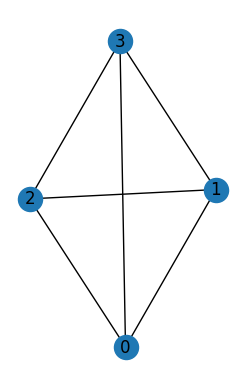

In [7]:
subax1 = plt.subplot(121)
nx.draw(CG, with_labels=True)

## create spanning tree + set orientations

In [8]:
# create "spanning" tree
tree = list(nx.edge_dfs(CG, source=0))

rng = np.random.default_rng(seed=42)
n_unorient = sum([CG.edges[rel]["orient"] == Orient.NONE for rel in tree])
new_orients = rng.integers(0, 6, len(tree)) # TODO FIX need to have fixed relationships..


for n, rel in zip(new_orients, tree):
    if CG.edges[rel]["orient"] == Orient.NONE:
        CG.edges[rel]["orient"] = Orient(n)


# FOR testing purposes, match Fig 16a, 3-2 has East(*-1) relationship => West (but edges are unidirectional for now, so keep as East...) 
CG.edges[2,3]["orient"] = Orient.EAST


for n in tree:
    print([n, CG.edges[n]["orient"]])
# TODO organize so that for single unit dif, early numbers come first, until reach last unit. Then  later numbers come first


[(0, 1), <Orient.SOUTH: 2>]
[(1, 2), <Orient.WEST: 4>]
[(2, 0), <Orient.EAST: 3>]
[(0, 3), <Orient.SOUTH: 2>]
[(3, 1), <Orient.SOUTH: 2>]
[(3, 2), <Orient.EAST: 3>]


# Create spatial units

In [299]:
p = cn.Problem()
p.addVariable("x", range(10))
p.getSolutions()




[{'x': 9},
 {'x': 8},
 {'x': 7},
 {'x': 6},
 {'x': 5},
 {'x': 4},
 {'x': 3},
 {'x': 2},
 {'x': 1},
 {'x': 0}]

In [292]:
p.addConstraint(lambda x: x < 2, ("x"))

In [300]:
p.addConstraint(cn.InSetConstraint([2+2]))

In [301]:
p.getSolutions()

[{'x': 4}]

In [358]:
class Face(cn.Problem):
    def __init__(self, face):
        cn.Problem.__init__(self)
        nrange = range(-100, 100)
        self.addVariable(face, nrange)
        self.axis = face



    def get_face_sol(self):
        assert len(self.getSolutions()) == 1, "Not a unique solution"
        self.solution = [*self.getSolution().values()][0]
        return self.solution

In [329]:
class NodeFaces():
    def __init__(self):
        self.faceN = Face("y")
        self.faceS = Face("y")
        self.faceE = Face("x")
        self.faceW = Face("x")
        self.faceT = Face("z")
        self.faceB = Face("z")
    
    def see_curr_sols(self):
        face_sols = {}
        for face in vars(self):
            curr_sols = [list(z.values())[0] for z in self.__getattribute__(face).getSolutions()]
            if len(curr_sols) < 1:
                face_sols[face] = "No Solutions"

            elif len(curr_sols) == 1:
                face_sols[face] = curr_sols[0]
            else:
                face_sols[face] = {
                    "min": min(curr_sols),
                    "max": max(curr_sols),
                }
    
        return face_sols


In [321]:
class SpatialUnitProperties:
    def __init__(self, name="Test", length=1, width=1, height=1, level_height=0):
        self.name = name
        self.length = length
        self.width = width
        self.height = height
        self.level_height = level_height

In [376]:
def set_matching_face(f1: Face, f2:Face, sup):
    # TODO s is a member of SpatialUnitProperties
    poss_sols = [[*sol.values()][0] + sup for sol in f2.getSolutionIter()]
    return f1.addConstraint(cn.InSetConstraint(poss_sols))

def set_face_relation(n: NodeFaces, f: Face, s: SpatialUnitProperties):
    d = {
        "y": ("faceS", "faceN", s.width),
        "x": ("faceW", "faceE", s.length),
        "z": ("faceB", "faceT", s.height)
    }

    f1, f2, s = [*d[f.axis]]
    return set_matching_face(n.__getattribute__(f1), n.__getattribute__(f2), s)
                
    

In [360]:
# doing manually to begin ...

# for node 0... -> bottom at 0 
n0 = NodeFaces()
n0.faceB.addConstraint(cn.InSetConstraint([CG.nodes[0]["lev_height"]])) 
n0.faceW.addConstraint(cn.InSetConstraint([0]))
n0.faceS.addConstraint(cn.InSetConstraint([0]))

# set relationship with other faces
s1 = SpatialUnitProperties()
# now need to set incrementally 
# set_face_relations(n0, s1) #.see_curr_sols()



0


In [361]:
n0.see_curr_sols()

{'faceN': 1, 'faceS': 0, 'faceE': 1, 'faceW': 0, 'faceT': 1, 'faceB': 0}

In [340]:
def add_orientation_constraint(face1, face2_val):
    print(face1, face2_val)
    return face1.addConstraint(lambda x: x > face2_val)


def orient_ij(ni, nj, orient):
    d = {
        Orient.SOUTH : (nj.faceN, ni.faceS.get_face_sol()),
        Orient.WEST : (nj.faceE, ni.faceW.get_face_sol()),  
        Orient.BOTTOM : (nj.faceT, ni.faceB.get_face_sol())
    }

    add_orientation_constraint(*d[orient])
    return 
    

In [341]:
n1 = NodeFaces()
n1.see_curr_sols()

{'faceN': {'min': -100, 'max': 99},
 'faceS': {'min': -100, 'max': 99},
 'faceE': {'min': -100, 'max': 99},
 'faceW': {'min': -100, 'max': 99},
 'faceT': {'min': -100, 'max': 99},
 'faceB': {'min': -100, 'max': 99}}

In [331]:
# n1.faceN.addConstraint(lambda x: x > 10)

In [342]:
orient_ij(n0, n1, Orient.BOTTOM)

<__main__.Face object at 0x11ffb7460> 0


In [343]:
n1.see_curr_sols() # TODO issue -> running  all when begin + numbers are messed up -> switch around 

{'faceN': {'min': -100, 'max': 99},
 'faceS': {'min': -100, 'max': 99},
 'faceE': {'min': -100, 'max': 99},
 'faceW': {'min': -100, 'max': 99},
 'faceT': {'min': 1, 'max': 99},
 'faceB': {'min': -100, 'max': 99}}